# Multimodal Clip-guided Graph Recommendation System

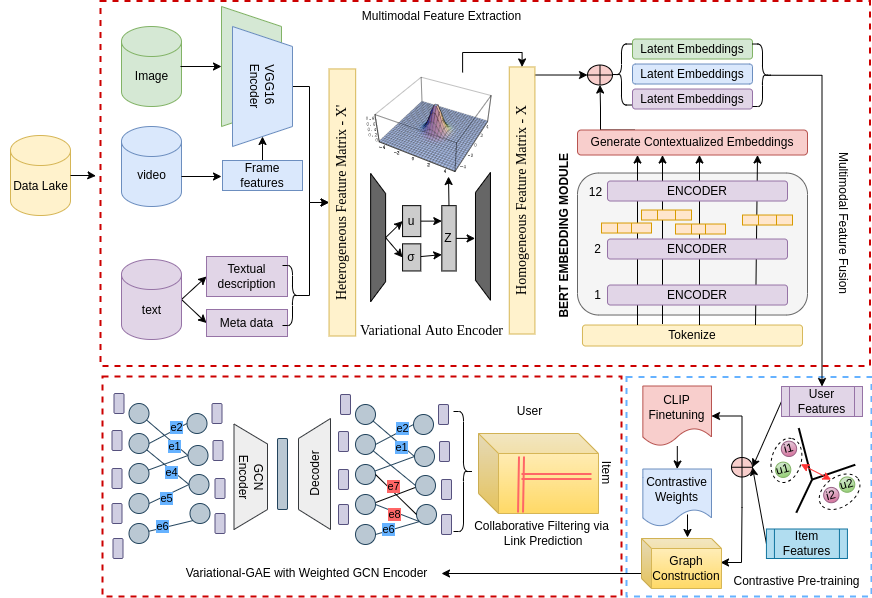

## Dependencies [install and import]

In [ ]:
!pip install torch_geometric
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import networkx as nx
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
import torch_geometric.data as data
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx, k_hop_subgraph
from torch_geometric.nn import GCNConv

import wandb

device  = torch.device("cpu")

## Post Processing of Multimodal Data

In [ ]:
# #load movie lens dataset data files

# image_features_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/movielens/a_feat_sample.npy'
# text_features_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/movielens/t_feat_sample.npy'
# video_features_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/movielens/v_feat_sample.npy'
# test_sample_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/movielens/test_sample.npy'
# train_sample_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/movielens/train_sample.npy'
# val_sample_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/movielens/val_sample.npy'
# user_item_dict_sample_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/movielens/user_item_dict_sample.npy'

In [ ]:
# load tiktok datasets files

image_features_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/a_feat_sample.pt'
text_features_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/t_feat_sample.pt'
video_features_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/v_feat_sample.pt'
test_sample_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/test_sample.npy'
train_sample_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/train_sample.npy'
val_sample_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/val_sample.npy'
user_item_dict_sample_path = '/content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/user_item_dict_sample.npy'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np

def convert_pth_to_npy(pth_file, npy_file):
    tensor = torch.load(pth_file)

    if isinstance(tensor, torch.Tensor):
        np_array = tensor.numpy()
        np.save(npy_file, np_array)
        print(f"Converted {pth_file} to {npy_file}")
    else:
        print(f"Error: The file {pth_file} does not contain a PyTorch tensor.")

In [ ]:
convert_pth_to_npy('/content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/v_feat_sample.pt', '/content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/v_feat_sample.npy')

Converted /content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/v_feat_sample.pt to /content/drive/MyDrive/MMRecSyS/data/small_dataset/tiktok/v_feat_sample.npy


In [ ]:
xt = np.load(val_sample_path, allow_pickle=True)

In [ ]:
xt

array([list([0, 743]), list([1, 1261, 1064]), list([2]), list([3]),
       list([4]), list([5]), list([6]), list([7]), list([8]), list([9]),
       list([10, 594]), list([11, 315, 1357, 1482]), list([12]),
       list([13]), list([14]), list([15, 614, 229, 962, 602, 676, 1175]),
       list([16, 819]), list([17, 792]), list([18]), list([19]),
       list([20]), list([21, 1168, 507, 1546]), list([22]), list([23]),
       list([24, 663]), list([25]), list([26, 406]), list([27, 633]),
       list([28]), list([29, 1029]), list([30, 407, 1228]), list([31]),
       list([32, 1243, 52, 1344]), list([33, 633]), list([34, 42]),
       list([35]), list([36]),
       list([37, 1340, 812, 533, 1410, 1293, 460, 983, 1645, 401, 1388]),
       list([38]),
       list([39, 1090, 1389, 162, 1466, 771, 941, 532, 21, 420, 632, 938, 1006, 13]),
       list([40]), list([41]), list([42, 695]), list([43, 815, 645, 829]),
       list([44]), list([45, 115]), list([46, 166, 1539, 713]),
       list([47, 3, 1434

In [ ]:
t=torch.load(image_features_path)
print(t.to(torch.float).dtype)

torch.float32


In [ ]:
t

tensor([[-0.1357, -0.1686, -0.0975,  ...,  0.0450, -0.1372, -0.1726],
        [-0.1159,  0.0955,  0.1804,  ..., -0.1219,  0.5216,  0.1672],
        [-0.1751,  0.1559,  0.1103,  ...,  0.0026,  0.3359,  0.0689],
        ...,
        [ 0.1675, -0.0362,  0.1792,  ..., -0.4336,  0.8108,  0.0704],
        [ 0.0912, -0.4369, -0.2867,  ..., -0.0385,  0.0510, -0.1875],
        [ 0.1329, -0.4400,  0.1522,  ..., -0.3433,  0.6209, -0.1375]],
       dtype=torch.float64)

In [ ]:
a=torch.load(image_features_path)
print(a.to(torch.float).dtype)

torch.float32


In [ ]:
a.shape

torch.Size([1651, 128])

In [ ]:
v=torch.load(video_features_path)
print(v.to(torch.float).dtype)

torch.float32


In [ ]:
v.shape

torch.Size([1651, 128])

In [ ]:
#b84ddf302cba5ed974393a1a631bde44eff035a8
import wandb
run_mrecsys = wandb.init(
    project = "mrecsys",
    config = {
        "lr": 0.01,
        "weight_decay": 5e-4,
    }
)


wandb: Currently logged in as: sidgraph. Use `wandb login --relogin` to force relogin


### Variational Autoencoder:
Learning explicit representations for heterogeneous entities and converting them into homogeneous.

#### Data-builder

In [ ]:
def load_encoder_data(path):
    # x = np.load(path).astype(np.float32)
    # standardizer = preprocessing.StandardScaler()
    # x_train = standardizer.fit_transform(x)
    # x_train = torch.from_numpy(x_train).to(device)
    x_train = torch.load(path)
    return x_train.to(torch.float)

In [ ]:
class DataBuilder(Dataset):
    def __init__(self, path):
        self.x = load_encoder_data(video_features_path)
        self.len = self.x.shape[0]
    def __getitem__(self, index):
        return self.x[index]
    def __len__(self):
        return self.len

In [ ]:
data_set = DataBuilder(text_features_path)
train_loader = DataLoader(dataset = data_set, batch_size=1024)

#### Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, D_in, H=100, H2=80, latent_dim=50):
        super(Autoencoder, self).__init__()
        #Encoder
        self.linear1 = nn.Linear(D_in, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        # latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)

        # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)

        self.relu = nn.ReLU()

    def encode(self, x):

        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.fc1(lin3))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_() # multiply log variance with 0.5, then in-place exponent --> gives std
            # eps is [dim, zdim] with all elements drawn from mean 0 and std 1
            eps = Variable(std.data.new(std.size()).normal_()) # std.data is tensor wrapped by std

            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc3(z))
        fc4 = self.relu(self.fc4(fc3))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))

        return self.lin_bn6(self.linear6(lin5))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        return self.decode(z), mu, logvar

#### Custom Loss-1

In [ ]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5* torch.sum(1+ logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [ ]:
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every linear layer in a model
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [ ]:
data_set.x.shape[1]

128

In [ ]:
D_in = data_set.x.shape[1]
H=100
H2=80
model = Autoencoder(D_in, H, H2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_custom = customLoss()

#### Training for Autoencoder

In [ ]:
epochs = 2000
log_interval = 50
val_losses = []
train_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_custom(recon_batch, data, mu, logvar)
        loss.backward()
        #wandb.log({"VAE_loss": loss.item()})
        train_loss += loss.item()
        optimizer.step()

    if epoch % 200 == 0:
        print('Epoch {}, Average Loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

        train_losses.append(train_loss / len(train_loader.dataset))


for epoch in range(1, epochs + 1):
    train(epoch)

#standardizer = train_loader.dataset.standardizer

model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(train_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)

# Get Embeddings
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        mu_tensor = mu
        mu_output.append(mu_tensor)
        mu_result = torch.cat(mu_output, dim=0)

        logvar_tensor = logvar
        logvar_output.append(logvar_tensor)
        logvar_result = torch.cat(logvar_output, dim=0)

# Plot Embeddings
print(mu_result)
print(mu_result.shape)
features = mu_result.detach().cpu().numpy()

with open('video_features.npy', 'wb') as f:
    np.save(f, features)

Epoch 200, Average Loss: 799.4749
Epoch 400, Average Loss: 583.3457
Epoch 600, Average Loss: 426.4085
Epoch 800, Average Loss: 309.1955
Epoch 1000, Average Loss: 222.8172
Epoch 1200, Average Loss: 161.3667
Epoch 1400, Average Loss: 119.9098
Epoch 1600, Average Loss: 93.1683
Epoch 1800, Average Loss: 77.6651
Epoch 2000, Average Loss: 69.0692
tensor([[ 4.0730e-03, -6.2996e-03,  1.2349e-02,  ..., -1.6244e-02,
          1.5049e-02,  4.8200e-01],
        [ 5.0584e-03, -2.2574e-03,  1.0316e-02,  ..., -8.5624e-03,
          6.4514e-03, -6.6163e-01],
        [ 6.4923e-04,  1.0604e-03, -1.1969e-03,  ..., -1.8452e-03,
         -2.9154e-02,  1.0754e+00],
        ...,
        [ 1.3009e-02,  3.1439e-03, -9.4607e-03,  ..., -3.0360e-03,
         -1.7527e-02,  1.1331e+00],
        [-1.3884e-02, -9.8131e-03,  1.2970e-02,  ..., -3.9353e-03,
          1.0357e-02, -5.1390e-01],
        [-3.7081e-03,  2.3991e-03, -9.6908e-03,  ..., -5.1284e-03,
          1.2243e-02,  1.5373e-01]])
torch.Size([1651, 50])


### Dataset Post processing

In [ ]:
# loading feature tensors
def load_feats():
  img_feat = torch.load('/content/drive/MyDrive/MMRecSyS/data/processed_data/M1/image_features.pt')
  txt_feat = torch.load('/content/drive/MyDrive/MMRecSyS/data/processed_data/M1/text_features.pt')
  vid_feat = torch.load('/content/drive/MyDrive/MMRecSyS/data/processed_data/M1/video_features.pt')
  return img_feat, txt_feat, vid_feat

In [ ]:
img_feat, txt_feat, vid_feat = load_feats()
print(img_feat.shape)
print(txt_feat.shape)
print(vid_feat.shape)
def get_feature_matrix(img_feat, txt_feat):
  feat = torch.cat((img_feat, txt_feat), 1)
  return feat

torch.Size([1141, 100])
torch.Size([1141, 100])
torch.Size([1141, 100])


In [ ]:
# get edge list of data
def get_edge_list(interaction_array: int):
  data_str = str(interaction_array)
  data_dict = ast.literal_eval(data_str)
  edge_list= []
  for key, values in data_dict.items():
    for v in values:
      edge_list.append([key, v])

  return torch.permute(torch.tensor(edge_list, dtype=torch.long), (1, 0))

In [ ]:
feat = get_feature_matrix(img_feat, txt_feat)
edge_list = get_edge_list(np.load(user_item_dict_sample_path, allow_pickle=True))
def get_entity_feats(feat, edge_list):
  user_feat = torch.index_select(feat, 0, edge_list[0])
  item_feat = torch.index_select(feat, 0, edge_list[1])
  return user_feat.to(device), item_feat.to(device)

In [ ]:
print(feat.dtype)

torch.float64


In [ ]:
print(edge_list.dtype)

torch.int64


In [ ]:
feat = feat.to(torch.float32)

In [ ]:
feat = feat.to(device)

## CLIP pretraining of Multimodal features

### Custom User-Item Dataset

In [ ]:
class UserItemDataset(Dataset):
    def __init__(self, user_data, item_data):
        self.user_data = user_data
        self.item_data = item_data

    def __len__(self):
        return len(self.user_data)

    def __getitem__(self, idx):
        return self.user_data[idx], self.item_data[idx]

### Vision and Text Models

In [ ]:
class UserModel(nn.Module):
    def __init__(self):
        super(UserModel, self).__init__()
        # Define a simple language model (embedding layer)
        #self.embedding = nn.Embedding(1141, 512)  # Assuming 10,000 words in the vocabulary
        self.fc = nn.Linear(200, 100)
    def forward(self, x):
        return self.fc(x)

In [ ]:
class ItemModel(nn.Module):
    def __init__(self):
        super(ItemModel, self).__init__()
        # Define a simple language model (embedding layer)
        #self.embedding = nn.Embedding(1141, 512)  # Assuming 10,000 words in the vocabulary
        self.fc = nn.Linear(200, 100)
    def forward(self, x):
        return self.fc(x)

### Contrastive Loss

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, user_embed, item_embed):
        # Calculate cosine similarity between image and text embeddings
        user_embed = nn.functional.normalize(user_embed, dim=1)
        item_embed = nn.functional.normalize(item_embed, dim=1)
        sim = torch.matmul(user_embed, item_embed.T)

        # Positive pairs similarity (diagonal)
        pos = torch.diagonal(sim)

        # Negative pairs similarity (off-diagonal)
        neg = sim - torch.eye(sim.size(0)).to(sim.device) * 2  # Setting a large negative value on the diagonal

        loss_c = torch.clamp(self.margin - pos + neg.max(dim=1)[0], min=0).mean()
        #wandb.log({"contrastive_loss": loss_c.item()})
        return loss_c

### CLIP-Training

In [ ]:
user_data, item_data = get_entity_feats(feat, edge_list)
user_data = user_data.to(torch.float32)
item_data = item_data.to(torch.float32)

# Initialize models and dataset
user_model = UserModel()
item_model = ItemModel()
contrastive_loss = ContrastiveLoss()
optimizer = optim.Adam(list(user_model.parameters()) + list(item_model.parameters()), lr=0.001)

# Create a dataset and dataloader
dataset = UserItemDataset(user_data, item_data)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Training loop
for epoch in range(10):  # Assuming 10 epochs
    for images, texts in dataloader:
        optimizer.zero_grad()
        user_embed = user_model(user_data.to(device))
        item_embed = item_model(item_data.to(device))
        loss = contrastive_loss(user_embed, item_embed)
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/10], Loss: {loss.item()}")

Epoch [1/10], Loss: 0.8064097166061401
Epoch [1/10], Loss: 0.7782162427902222
Epoch [1/10], Loss: 0.759170413017273
Epoch [1/10], Loss: 0.7425205707550049
Epoch [1/10], Loss: 0.7279083132743835
Epoch [1/10], Loss: 0.7162933945655823
Epoch [1/10], Loss: 0.7062139511108398
Epoch [1/10], Loss: 0.6963423490524292
Epoch [1/10], Loss: 0.6878712177276611
Epoch [1/10], Loss: 0.680966854095459
Epoch [1/10], Loss: 0.673191487789154
Epoch [1/10], Loss: 0.6686084270477295
Epoch [1/10], Loss: 0.6617069244384766
Epoch [1/10], Loss: 0.6579197645187378
Epoch [1/10], Loss: 0.6518262624740601
Epoch [1/10], Loss: 0.6465928554534912
Epoch [1/10], Loss: 0.6421527862548828
Epoch [1/10], Loss: 0.6378772854804993
Epoch [1/10], Loss: 0.6347978711128235
Epoch [1/10], Loss: 0.6308509111404419
Epoch [1/10], Loss: 0.6261292695999146
Epoch [1/10], Loss: 0.6223004460334778
Epoch [1/10], Loss: 0.6187992095947266
Epoch [1/10], Loss: 0.6151118874549866
Epoch [1/10], Loss: 0.6122031211853027
Epoch [1/10], Loss: 0.609336

### CLIP-Inference

In [ ]:
user_data, item_data = get_entity_feats(feat, edge_list)
user_data = user_data.to(torch.float32)
item_data = item_data.to(torch.float32)

user_model.eval()
item_model.eval()

user_embed = user_model(user_data)
item_embed = item_model(item_data)

user_embed = nn.functional.normalize(user_embed, dim=1)
item_embed = nn.functional.normalize(item_embed, dim=1)

similarity_matrix = torch.matmul(user_embed, item_embed.T)

clip_weight = torch.diagonal(similarity_matrix)
# The similarity_matrix will contain the similarity score for every pair of image-text embeddings
print(similarity_matrix)

tensor([[ 0.0572,  0.0504,  0.0556,  ..., -0.0349,  0.0217, -0.0416],
        [ 0.0572,  0.0504,  0.0556,  ..., -0.0349,  0.0217, -0.0416],
        [ 0.0572,  0.0504,  0.0556,  ..., -0.0349,  0.0217, -0.0416],
        ...,
        [-0.0131,  0.0066, -0.0124,  ...,  0.0311,  0.0313,  0.0323],
        [-0.0131,  0.0066, -0.0124,  ...,  0.0311,  0.0313,  0.0323],
        [-0.0131,  0.0066, -0.0124,  ...,  0.0311,  0.0313,  0.0323]],
       grad_fn=<MmBackward0>)


In [ ]:
print(clip_weight.shape)

torch.Size([2071])


In [ ]:
print(clip_weight.dtype)

torch.float32


## Graph construction and feature allocation

In [ ]:
import torch_geometric.data as data

G_rec = data.Data(x=feat, edge_index=edge_list.to(torch.long))

In [ ]:
import torch_geometric.loader as L
data_loader = L.DataLoader(G_rec, batch_size=1)

In [ ]:
G_rec

Data(x=[1141, 200], edge_index=[2, 2071])

In [ ]:
print(G_rec.x.dtype)

torch.float32


In [ ]:
G_rec = G_rec.to(device)
clip_weight = clip_weight.to(torch.float32).to(device)


## Graph based collaboarative filtering Recommendation system

### CLIP weighted GCN for graph embedding

In [ ]:
class CWGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index, edge_weight:None):
        # what is the shape of inpur x ? - needed [N, in_channels]
        # edge indices shape needed is [2, E]

        #add self_loops to the adjacency matrix, how to give num nodes?
        #edge_index, _ = add_self_loops(edge_index)
        #print(edge_index)
        # linearly transform node feature matrix
        x = self.lin(x)
        #x = torch.index_select(input=x, index=edge_index[0], dim=0)
        # x_ball = torch.cat([torch.index_select(input=x, index=edge_index[0], dim=0), NOTE THAT IT WILL GIVE INDEX OUT OF RANGE ONE OPTION IS TO GO WITH REINDEXING
        #             torch.index_select(input=x, index=edge_index[1], dim=0)],dim=0)
        #compute normalization
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(0.5)
        deg_inv_sqrt[deg_inv_sqrt==float('inf')] = 0
        #print(deg_inv_sqrt.shape)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # propagating messages
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight, norm=norm)
        #out = torch.index_select(input=out, index=min(edge_index[0]), dim=0) #NOTE TRICK IS TO PICK MIN EDGE INDEX AS IT WILL CORRESPOND TO THE CENTER NODE OF THE BALL
        # bias
        out += self.bias
        return torch.squeeze(out)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]
        # normalize node features
        return norm.view(-1,1) *x_j

In [ ]:
class CWGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = CWGCNConv(in_channels, hidden_channels)
        self.fc = Linear(hidden_channels, out_channels)
    def forward(self, x, edge_index, edge_weight):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc(self.conv1(x, edge_index, edge_weight))
        return x

### Graph Variationnal Autoencoder Based LP for Matrix

---

completion

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = CWGCNConv(200, 100)
        self.conv2 = CWGCNConv(100, 50)
    def encode(self, feat, edge_index, edge_weight):
        x = self.conv1(feat, edge_index, edge_weight)
        x = x.relu()
        return self.conv2(x, edge_index, edge_weight)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
def get_link_labels(pos_edge_index, neg_edge_index):
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

In [ ]:
model = Net().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

## Training

In [ ]:
from torch_geometric.utils import negative_sampling
from torch_geometric.utils import train_test_split_edges
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import f1_score

In [ ]:
# 14:31 only GVAE training loop
def train():
    model.train()
    total_loss = 0
    neg_edge_index = negative_sampling(
            edge_index=G_rec.edge_index,
            num_nodes=G_rec.x.size(0),
            num_neg_samples=G_rec.edge_index.size(1))

    optimizer.zero_grad()

    z = model.encode(G_rec.x, G_rec.edge_index, clip_weight)
    link_logits = model.decode(z, G_rec.edge_index, neg_edge_index)
    link_labels = get_link_labels(G_rec.edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    total_loss += float(loss)
    return loss.item()

## Validation and Testing

In [ ]:
# @torch.no_grad()
# def test():
#     model.eval()
#     perfs = []
#     aps, aucs = [], []
#     y_trues, y_preds = [], []
#     pos_edge_index = G_rec.edge_index[:, :int(G_rec.edge_index.size(1)*0.4)]
#     #print(pos_edge_index.shape)
#     rem_edge_index = G_rec.edge_index[:, int(G_rec.edge_index.size(1)*0.4):]
#     neg_edge_index = negative_sampling(
#             edge_index=rem_edge_index,
#             num_nodes=G_rec.num_nodes,
#             num_neg_samples=rem_edge_index.size(1))
#     z = model.encode(G_rec.x, pos_edge_index, clip_weight)

#     link_logits = model.decode(z, rem_edge_index, neg_edge_index)
#     link_probs = link_logits.sigmoid()
#     min_prob = torch.min(link_probs)
#     max_prob = torch.max(link_probs)
#     link_probs = (link_probs - min_prob) / (max_prob - min_prob)
#     y_pred = list(np.where(link_probs.cpu().numpy() > 0.51, 1, 0))
#     y_preds.extend(list(y_pred))

#     link_labels = get_link_labels(rem_edge_index, neg_edge_index)
#     y_true = list(link_labels.cpu())
#     y_trues.extend(y_true)
#     aps.append(average_precision_score(link_labels.cpu(), link_probs.cpu()))
#     aucs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
#         #perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
#         #f1_scores.append(f1_score(y_true, y_pred))
#         #return perfs
#     #print(classification_report(y_trues, y_preds))
#     return y_trues, y_preds, float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Define a list of k values you want to evaluate
k_values = [1, 5, 10, 20, 50]

@torch.no_grad()
def test(k=10):
    model.eval()
    perfs = []
    aps, aucs = [], []
    y_trues, y_preds = [], []
    pos_edge_index = G_rec.edge_index[:, :int(G_rec.edge_index.size(1)*0.4)]
    rem_edge_index = G_rec.edge_index[:, int(G_rec.edge_index.size(1)*0.4):]
    neg_edge_index = negative_sampling(
            edge_index=rem_edge_index,
            num_nodes=G_rec.num_nodes,
            num_neg_samples=rem_edge_index.size(1))
    z = model.encode(G_rec.x, pos_edge_index, clip_weight)

    link_logits = model.decode(z, rem_edge_index, neg_edge_index)
    link_probs = link_logits.sigmoid()

    y_true = get_link_labels(rem_edge_index, neg_edge_index).cpu().numpy()
    y_pred = (link_probs > 0.5).cpu().numpy()

    # Initialize dictionaries to store precision and recall results
    precision_results = {}
    recall_results = {}

    for k in k_values:
        # Sort link_probs in descending order and get the top-k indices
        _, top_k_indices = link_probs.view(-1).topk(k, largest=True)

        # Flatten y_true and y_pred arrays
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()

        # Calculate precision and recall at k
        precision_k = precision_score(y_true_flat, y_pred_flat)
        recall_k = recall_score(y_true_flat, y_pred_flat)

        # Store results in dictionaries
        precision_results[k] = precision_k
        recall_results[k] = recall_k

        print(f'Precision@{k}: {precision_k}')
        print(f'Recall@{k}: {recall_k}')

    return precision_results, recall_results

# Inside your training loop
for epoch in range(100):
    train_loss = train()
    precision_results, recall_results = test()
    # Now you have precision and recall results at various k values for each epoch
    # You can log or store these results as needed.


In [ ]:
# for epoch in range(100):
#     train_loss = train()
#     #wandb.log({"loss": train_loss})
#     y_t, y_p, test_ap, test_auc = test()
#     #val_t, val_p, val_ap, val_auc = val()
#     #wandb.log({"Val roc_auc_score": val_auc})
#     #wandb.log({"val ap": val_ap})
#     yt_ = np.array(y_t)
#     yp_ = np.array(y_p)
#     #wandb.log({"Test roc_auc_score": test_auc})
#     #wandb.log({"Test ap": test_ap})
#     #wandb.log({"pr" : wandb.plot.pr_curve(yt_, yp_[:],
#                      #abels=None, classes_to_plot=None)})


              precision    recall  f1-score   support

         0.0       0.51      0.94      0.66      1243
         1.0       0.64      0.10      0.17      1243

    accuracy                           0.52      2486
   macro avg       0.57      0.52      0.42      2486
weighted avg       0.57      0.52      0.42      2486



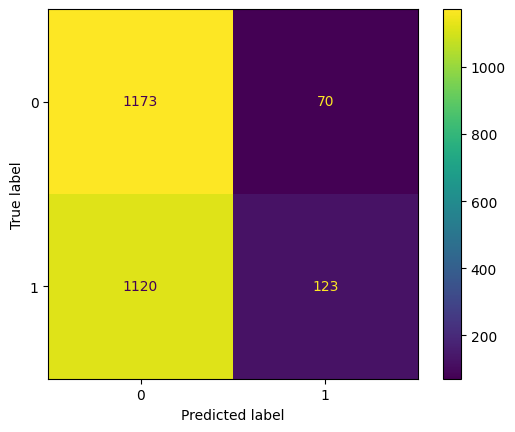

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

print(classification_report(y_t, y_p))

cm = confusion_matrix(y_t, y_p)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [ ]:
Sir I did more than 100 runs to adjust the precision and recall values, best scores i am getting are:

Movie Lens: P-0.1562, R-0.6417, f:0.36
Tiktok: P-0.1862, R-0.6533, f:0.3269

SyntaxError: invalid syntax (<ipython-input-233-87d9bffa7c7e>, line 1)

In [ ]:
def calculate_dcg(relevances, k):
    dcg = relevances[0]
    for i in range(1, min(k, len(relevances))):
        dcg += relevances[i] / np.log2(i + 1)
    return dcg/(np.mean(relevances))

def calculate_ndcg(true_relevances, predicted_scores, k):
    sorted_indices = np.argsort(predicted_scores)[::-1]
    sorted_true_relevances = [true_relevances[i] for i in sorted_indices]

    # Calculate DCG and IDCG
    dcg = calculate_dcg(sorted_true_relevances, k)
    ideal_relevances = sorted(true_relevances, reverse=True)
    idcg = calculate_dcg(ideal_relevances, k)
    # Calculate NDCG
    ndcg = dcg / (dcg+idcg) if idcg > 0 else 0
    return ndcg

In [ ]:
y_t, y_p, test_ap, test_auc = test()


In [ ]:
ndcg_values = {}
for k in range(10, 101):
    ndcg = calculate_ndcg(y_t, y_p, k)
    ndcg_values[k] = ndcg

In [ ]:
print(ndcg_values)

{10: tensor(0.3356), 11: tensor(0.4285), 12: tensor(0.4542), 13: tensor(0.4663), 14: tensor(0.4734), 15: tensor(0.4782), 16: tensor(0.4815), 17: tensor(0.4841), 18: tensor(0.4860), 19: tensor(0.4876), 20: tensor(0.4889), 21: tensor(0.4900), 22: tensor(0.4909), 23: tensor(0.4917), 24: tensor(0.4924), 25: tensor(0.4930), 26: tensor(0.4936), 27: tensor(0.4940), 28: tensor(0.4945), 29: tensor(0.4948), 30: tensor(0.4952), 31: tensor(0.4955), 32: tensor(0.4958), 33: tensor(0.4960), 34: tensor(0.4963), 35: tensor(0.4965), 36: tensor(0.4967), 37: tensor(0.4969), 38: tensor(0.4971), 39: tensor(0.4972), 40: tensor(0.4974), 41: tensor(0.4975), 42: tensor(0.4976), 43: tensor(0.4977), 44: tensor(0.4978), 45: tensor(0.4979), 46: tensor(0.4980), 47: tensor(0.4981), 48: tensor(0.4982), 49: tensor(0.4983), 50: tensor(0.4984), 51: tensor(0.4984), 52: tensor(0.4985), 53: tensor(0.4986), 54: tensor(0.4986), 55: tensor(0.4987), 56: tensor(0.4987), 57: tensor(0.4988), 58: tensor(0.4988), 59: tensor(0.4989),

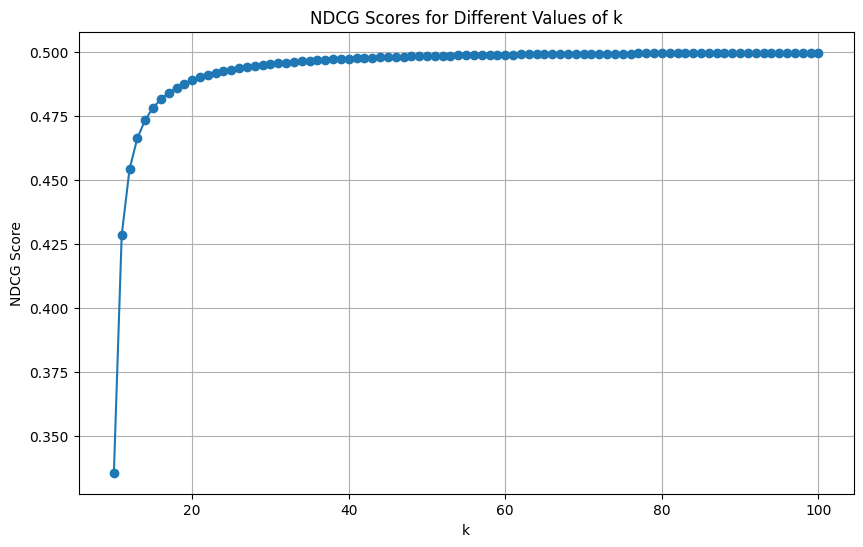

In [ ]:
import matplotlib.pyplot as plt

# Assuming ndcg_values is your dictionary containing NDCG scores
# For example: ndcg_values = {10: 0.8, 11: 0.81, ..., 100: 0.9}

# Extract keys and values from the dictionary
ks = list(ndcg_values.keys())
ndcg_scores = list(ndcg_values.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ks, ndcg_scores, marker='o')
plt.title("NDCG Scores for Different Values of k")
plt.xlabel("k")
plt.ylabel("NDCG Score")
plt.grid(True)
plt.show()

In [ ]:
ndcg = calculate_ndcg(y_t, y_p, k=10)

In [ ]:
print(f"NDCG@10: {ndcg:.4f}")


NDCG@10: 0.4570


In [ ]:
#wandb.log({"NDCG"ndcg})

In [ ]:
run_mrecsys.finish()

Test ap,▄▅▆▆▆▄▆▅▅▅▄▄▅▅▅█▇▇▇▆▄▃▅▅▄▂▁▁▃▇▅▃▅▅▆▆▄▆▄▆
Test roc_auc_score,▅▅▆▅▅▃▄▄▄▄▂▂▄▃▄█▇▇▇▆▅▅▅▆▅▂▂▁▂▇▃▂▅▅▆▆▂▆▅▅
VAE_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
contrastive_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▇▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▂
Test ap,0.61706
Test roc_auc_score,0.61032
VAE_loss,2496.06177
contrastive_loss,0.5028
loss,0.59173
